This script plots all the flood locations by day.

In [61]:
from db_scripts.get_server_data import data_dir, fig_dir
import pandas as pd
import matplotlib.pyplot as plt
import math
from mpl_toolkits.basemap import Basemap
import numpy as np
import shapefile

In [42]:
flood_df = pd.read_csv('{}norfolk_flooded_roads_data/STORM_data_flooded_streets_2010-2016_no_duplicates_clean_lat_lon.csv'.format(data_dir))

In [43]:
flood_df['_date'] = pd.to_datetime(flood_df['_date'])
all_dates = pd.to_datetime(flood_df['_date'].unique())
num_plots = len(all_dates)
num_plots

82

In [44]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in xrange(0, len(seq), size))

In [45]:
def get_num_rows(num_plots, ncols):
    return int(math.ceil(len(num_plots)/float(ncols)))

In [62]:
def get_outline_polygon():
    # read in shapefile for city outline
    d = "{}GIS/norfolk_boundary.shp"
    ps = shapefile.Reader(d)
    outline_poly = ps.iterShapes().next().__geo_interface__

    t = ()
    for i in range(len(outline_poly['coordinates'][0])):
        if outline_poly is not None:
            t += ((outline_poly['coordinates'][0][i][0]/1000,
                   outline_poly['coordinates'][0][i][1]/1000),)
    t = t,
    outline_poly['coordinates'] = t
    return outline_poly

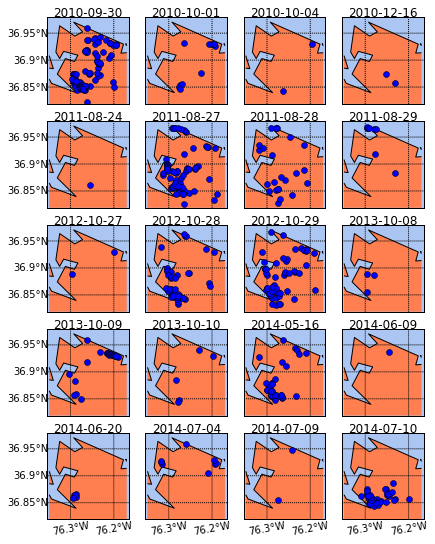

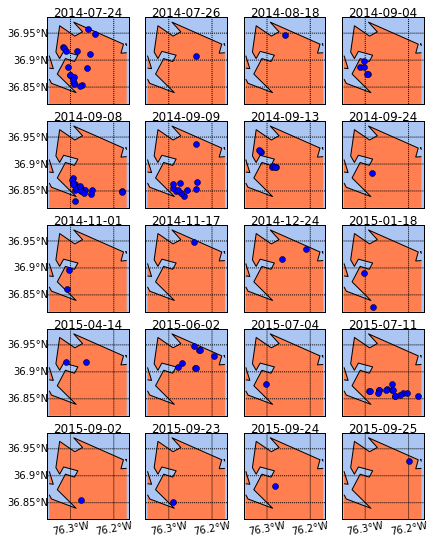

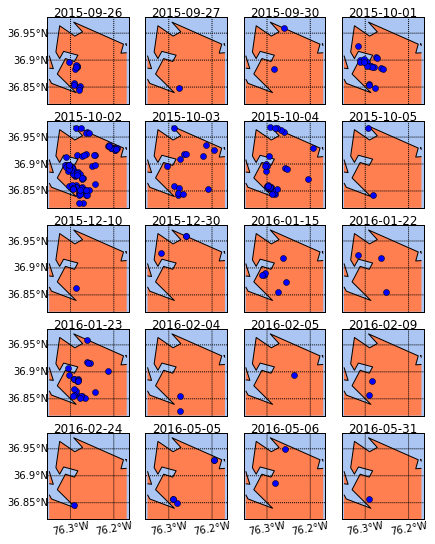

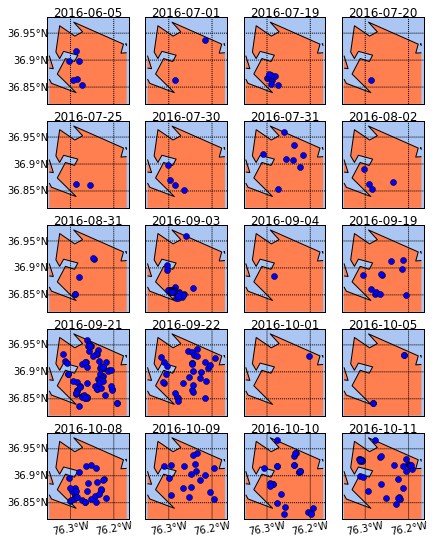

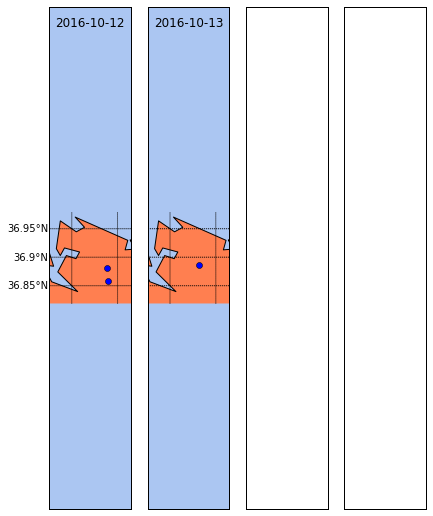

In [59]:
ncols = 4
for date_group in chunker(all_dates, 20):
    nrows = get_num_rows(date_group, ncols)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6.75, 9), sharex=True, sharey=True)
    ax_list = axs.ravel()
    for i in range(len(date_group)):
        plot_df = flood_df[flood_df['_date'] == date_group[i]]
        ax = ax_list[i]
        lats = flood_df['lat']
        lons = flood_df['lon']

        m = Basemap(resolution='i', projection='tmerc', lat_0 = lats.mean(), lon_0 = lons.mean(), ax=ax,
                    llcrnrlon=lons.min()*1.0004,llcrnrlat=lats.min()*0.9999,
                    urcrnrlon=lons.max()*0.9999,urcrnrlat=lats.max()*1.0003)

        m.drawcoastlines()
        m.drawmapboundary(fill_color='#abc6f2')
        m.fillcontinents(color = 'coral', lake_color='#abc6f2')

        latlabels = [1, 0, 0, 1] if i in [0, 4, 8, 12, 16] else [0, 0, 0, 0]
        lonlabels = [1, 0, 0, 1] if i > 15 else [0, 0, 0, 0]
        m.drawparallels(np.arange(34,38,0.05), labels=latlabels)
        meridians = m.drawmeridians(np.arange(-77, -75, 0.1), labels=lonlabels)
        for mer in meridians:
            try:
                meridians[mer][1][0].set_rotation(10)
            except:
                pass

        x,y = m(plot_df['lon'].tolist(), plot_df['lat'].tolist())
        m.plot(x, y, 'bo', markersize=6)
        ax.set_title(date_group[i].strftime('%Y-%m-%d'), y=0.95)
    plt.show()